# Capstone Project: Automatic Text Summarization

# Problem Statement

Having problem with too much content to read but too little time ? Get a summary that contains the key sentences using an extractive text summarizer.

# Executive Summary

Automatic Text Summarization is one of the most challenging and interesting problems in the field of Natural Language Processing (NLP). It is a process of generating a concise and meaningful summary of text from multiple text resources such as books, news articles, blog posts, research papers, emails, and tweets.

The demand for automatic text summarization systems is spiking these days thanks to the availability of large amounts of textual data.

In this project, we will work on single-document text summarization which is the task of automatically generating a shorter version of a document while retaining its most important information. 

This summarizer is able to read in a document from a text file, a PDF, from a URL or a block of text, uses three different models (Graph Based, Centriod Based, Pre-Trained Bert) to generate a summary based on the settings (by number of sentences, 1 min, 3 mins, 5 mins summary). 

Prototype URL : 

Import Required Libraries

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import networkx as nx
import requests
from bs4 import BeautifulSoup
from rouge import Rouge
import codecs
import PyPDF2

from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize

#settings to see all columns / rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


In [219]:
#import nltk
#nltk.download('punkt') # one time execution
#nltk.download('popular')

About Punkt Sentence Tokenizer

This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. It must be trained on a large collection of plaintext in the target language before it can be used.

The NLTK data package includes a pre-trained Punkt tokenizer for English.

# Input Document

## Document : A Text File

This function is used to read in the text of a text file.

In [220]:
def readFile(file_name):
    # open the file as read only
    # Return all the text in the file (in parapgraphs)
    with open(file_name) as file:
        text = [line.strip('\n') for line in file.readlines() if line.strip()] 
    # close the file
    file.close()
    return ' '.join(text)

## Document : A PDF

This function is used to read in the text of a PDF file.

In [221]:
def readPDF(file_name):
    text = []
    pdf_file_object = open(file_name, 'rb')
    print(pdf_file_object)
    pdfReader = PyPDF2.PdfFileReader(pdf_file_object)
    numPages = pdfReader.numPages
    print("No. of pages: ",numPages)
    for i in range(numPages):
        page_object = pdfReader.getPage(i).extractText().replace("\n","")        
        text.append(page_object)
        print("length of page: ",len(page_object))
    return text

## Document: An Url 

This function is used to read in the text of an URL. BeautifulSoup with lxml is used to extract the text from the website.

In [222]:
def readUrl(url): 
    
    #return the text of the article
    res = requests.get(url)
    res.status_code
    print(res.status_code)
    if res.status_code == 200:
        #create a beautifulsoup object
        soup = BeautifulSoup(res.content, 'lxml')
        text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
        return text
    else:
        print('Error assessing page, status = ' + str(res.status_code))   

## Document : A Block of Text

This function is used to read in the text entered by the user.

## Split Text into Sentences

These functions are used to get the wordcount, sentence count of the text source and split the text into sentences using NLTK sentence tokenizer.

In [223]:
def get_wordcount(text):
    # using regex (findall()) to count words in text 
    wc = len(re.findall(r'\w+', text)) 
    return(wc)

In [224]:
def get_sentencecount(text):
    # count no. of sentences in text   
    return len(sent_tokenize(text))

In [225]:
#function to split text into sentences using sent_tokenize and return the sentences
def get_sentences(text):
    
    sentences = sent_tokenize(text)

    return sentences

## Clean the Sentences

These 2 functions are used to clean individual sentence / all sentences at one go. Cleaning includes: 
- convert to lowercase
- remove stop words
- remove short words
- remove HTML tags
- Remove (‘s)
- Remove any text inside the parenthesis ( )
- Eliminate punctuations and special characters

In [226]:
stop_words = set(stopwords.words('english')) 
def clean_sentence(sentence,stop_words):
    # input : a sentence
    # output : a cleaned sentence
    
    #convert to lowercase
    new_sen = sentence.lower()
    
    #remove xml
    new_sen = BeautifulSoup(new_sen, 'lxml').text
    #new_sen = BeautifulSoup(new_sen, 'html.parser').get_text()
    
    #remove 's', punctuation, special characters, text in ()
    new_sen = re.sub(r'\([^)]*\)', '', new_sen)
    new_sen = re.sub('"','', new_sen)
    new_sen = re.sub(r"'s\b","",new_sen)
    new_sen = re.sub("[^a-zA-Z0-9]", " ", new_sen) 
       
    #remove stop_words
    tokens = [w for w in new_sen.split() if not w in stop_words]
    
    #remove short words
    long_words=[]
    for i in tokens:
        if len(i)>=1:                  
            long_words.append(i) 
    
    #if the new_sen is empty after cleaning, 
    #set the new_sen to "dummy", otherwise it will fail during sentence embedding as the index will not tally
    if len(long_words) == 0:
        long_words='dummy'
    return (' '.join(long_words)).strip()

In [227]:
def clean_all_sentences(sentences,stop_words):
    # input: list of sentences
    # output: list of cleaned sentences
    cleaned = []
    for s in sentences:
        s = clean_sentence(s,stop_words)
        cleaned.append(''.join(s))
    # remove empty sentence
    cleaned = [s for s in cleaned if len(s) > 0]
    return(cleaned)

# Model 1 : Graph-Based Summarization (TextRank)

In this section, we will create our first extractive text summarization model based on TextRank with GloVe word embeddings.

Global Vecotrs for Word Representations (GloVe, by Stanford) word embeddings are vector representation of words. These word embeddings will be used to create vectors for our sentences. We will be using the pre-trained Wikipedia 2014 + Gigaword 5 GloVe vectors. This is the smallest GloVe pre-trained model from the GloVe website. It an 822 Megabyte zip file with 4 different models (50, 100, 200 and 300-dimensional vectors) trained on Wikipedia data with 6 billion tokens and a 400,000 word vocabulary.

Word Embedding is an NLP technique, capable of capturing the context of a word in a document, semantic and syntactic similarity, relation with other words.

TextRank is an extractive and unsupervised text summarization technique. It is based on PageRank algorithm that is used on Google Search Engine. In simple words, it prefers pages which has higher number of pages hitting it. In our case, we are finding how similar each sentence is to all other sentences in the text. The most important sentence is the one that is most similar to all the others.
Extracted from : https://www.quora.com/What-is-a-simple-but-detailed-explanation-of-Textrank

TextRank Algorithm:
- Input article → split into sentences → remove stop words → build a similarity matrix → convert matrix to graph for sentence scoring and ranking → pick top N sentences for summary.

## Load GloVe Word Embeddings

In [228]:
def convert_to_binary(embedding_path):
    #function to split the text file to .npy and .vocab, faster way to load then reading .txt
    #input : location and name of glove text file, without the extension
    #output : a binary file of the embedding which is faster to load
 
    f = codecs.open(embedding_path + ".txt", 'r', encoding='utf-8')
    wv = []
    with codecs.open(embedding_path + ".vocab", "w", encoding='utf-8') as vocab_write:
        count = 0
        for line in f:
            if count == 0:
                pass
            else:
                splitlines = line.split()
                vocab_write.write(splitlines[0].strip())
                vocab_write.write("\n")
                wv.append([float(val) for val in splitlines[1:]])
            count += 1
    np.save(embedding_path + ".npy", np.array(wv))

In [229]:
def load_embeddings_binary(embedding_path):
    #function to load the glove model from .npy and .vocab
    #input : location and name of glove text file, without the extension
    #output : glove model

    with codecs.open(embedding_path + '.vocab', 'r', 'utf-8') as f_in:
        index2word = [line.strip() for line in f_in]
    wv = np.load(embedding_path + '.npy')
    word_embeddings = {}
    for i, w in enumerate(index2word):
        word_embeddings[w] = wv[i]
    return word_embeddings

## Create sentences vectors

This function is used to convert the sentence into sentence vectors  by applying glove word embedding. The sentence vector is calculated by summing all its individual word vectors divided by the sentence length.

In [230]:
def create_sentence_vectors(sentences, word_embeddings):
    #input : list of sentences, word embedding vectors
    #output  sentence matrix
    #sentence vectors = sum of word vectors in that sentence / length of sentence
    sentence_vectors = []
    for i in sentences:
        if len(i) != 0:
              v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((100,))
        sentence_vectors.append(v)
    return(sentence_vectors)

## Create Sentence Similarity Matrix 

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Since we will be representing our sentences as the bunch of vectors, we can use it to find the similarity among sentences. Its measures cosine of the angle between vectors. Angle will be 0 if sentences are similar.

In [231]:
# use cosine similarity to find similarity for a pair of sentences
# similarity matrix
def get_similarity_matrix(sentences,sentence_vectors):
    sim_mat = np.zeros([len(sentences), len(sentences)])

    for i in range(len(sentences)):
      for j in range(len(sentences)):
        if i != j:
          sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

    return(sim_mat)

## Sentence Scoring                          

For this step, we convert similarity martrix to graph and calculate the sentence score using pagerank algorithm.
The graph vertices represent the sentences, the edges are the scores.

In [232]:
# Convert matrix to graph 
def convert_matrix_to_graph(sim_mat):
    nx_graph = nx.from_numpy_array(sim_mat)
    return(nx_graph)

# Apply TextRank Algorithm to score the sentence
# The more similar a sentence is with all other sentences, the higher the score
def score_sentences(nx_graph):
    scores = nx.pagerank(nx_graph)
    return scores


## Sentence Ranking

This function is used to rank the sentences based on the similarity scores, sorted based the scores in descendign order.

In [233]:
def rank_sentences(sentences,scores):
       
    ranked_sentences = sorted(((scores[i],s,i) for i,s in enumerate(sentences)), 
                          reverse=True)
    return ranked_sentences

## Sentence Selection (Generated Summary)

This function is used to select the top sentences to form the summary. The top sentences can be sorted either by their scores or their original sentence orders(default).

In [234]:
# Extract top_n sentences as the summary, 
# input : 
#         ranked_sentneces: list of sentences with its score
#         top_n : number of sentences to extract
#         rank : whether the output will be sorted by rank order, default: False (sentence order)
# Output :
#         return list of top sentences in ranked order / sentence order

def extract_top_sentences(ranked_sentences,top_n, rank=False):

    if rank == True:
        s = ranked_sentences[0:top_n]
    else:
        s = sorted(ranked_sentences[0:top_n],key=lambda x: x[2])
    return [s[1] for s in s]

This is an enhanced function to the above by adding in the logic to check for sentence similarity before adding them into the summary.
e.g if a sentence to be selected is similar to the sentence already in summary, this sentence will not be selected.

In [235]:
def extract_top_sentences_sim_threshold(ranked_sentences,top_n, sim_mat,rank=False, sim_threshold = 0.95):

    sentence_scores_sort = ranked_sentences
    sentences_summary = []
    count = 1

    for s in sentence_scores_sort:

        if count > top_n:
            break
        include_flag = True
        for ps in sentences_summary:
            #sim = similarity(sim_mat[s[2]], sim_mat[ps[2]])
            sim = sim_mat[s[2]][ps[2]]

            # exclude similar sentences based on sim_threshold
            if sim > sim_threshold:
                include_flag = False
        if include_flag:
            sentences_summary.append(s)
            count += 1
            
    if rank == True:
        s = sentences_summary
    else:
        s = sorted(sentences_summary,key=lambda x: x[2])
    return [s[1] for s in s]           

## Function to generate a summary (all steps)

This function is used to generated the summary for all the steps listed above.

In [236]:
def generate_summary_textrank(text,top_n,word_embeddings):    
    
    # Get list of sentences
    sentences = get_sentences(text)
    
    # clean all sentences
    print('cleaning sentences ...')
    sentences_c = clean_all_sentences(sentences,stop_words)
    
    # Create word vectors for cleaned sentences
    print('creating word vectors for sentences ...')
    sentence_vectors = create_sentence_vectors(sentences_c,word_embeddings)
    
    # Get Sentence Similiarity Matrix
    print('creating sentence similarity matrix ...')
    sim_mat = get_similarity_matrix(sentences_c,sentence_vectors)
        
    # Convert matrix to graph and score sentences
    print('scoring sentences ...')
    nx_graph = convert_matrix_to_graph(sim_mat)
    scores = score_sentences(nx_graph)
    
    # Rank the sentences
    print('ranking sentences ...')
    ranked_sentences = rank_sentences(sentences,scores)
    
    # Extract top sentences & generate summary
    print('generating summary ...')
    generated_summary = extract_top_sentences(ranked_sentences,top_n)
    
    # apply similarity threshold in selection
    #generated_summary = extract_top_sentences_sim_threshold(ranked_sentences,top_n, sim_mat, rank=False, sim_threshold = 0.90)
    
    generated_summary = ' '.join(generated_summary)
    print('completed')
    return (generated_summary)

This is the enhanced function to the above (with similarity threshold checking) to generated the summary for all the steps.

In [237]:
def generate_summary_textrank_sim_threshold(text,top_n,word_embeddings):    
    
    # Get list of sentences
    sentences = get_sentences(text)
    
    # clean all sentences
    print('cleaning sentences ...')
    sentences_c = clean_all_sentences(sentences,stop_words)
    
    # Create word vectors for cleaned sentences
    print('creating word vectors for sentences ...')
    sentence_vectors = create_sentence_vectors(sentences_c,word_embeddings)
    
    # Get Sentence Similiarity Matrix
    print('creating sentence similarity matrix ...')
    sim_mat = get_similarity_matrix(sentences_c,sentence_vectors)
        
    # Convert matrix to graph and score sentences
    print('scoring sentences ...')
    nx_graph = convert_matrix_to_graph(sim_mat)
    scores = score_sentences(nx_graph)
    
    # Rank the sentences
    print('ranking sentences ...')
    ranked_sentences = rank_sentences(sentences,scores)
    
    # Extract top sentences & generate summary
    print('generating summary ...')
    #generated_summary = extract_top_sentences(ranked_sentences,top_n)
    
    # apply similarity threshold in selection
    generated_summary = extract_top_sentences_sim_threshold(ranked_sentences,top_n, sim_mat, rank=False, sim_threshold = 0.90)
    
    generated_summary = ' '.join(generated_summary)
    print('completed')
    return (generated_summary)

## Sample Test Case

In this section, we run a simple test case based on a block of text to test out all the steps in generating a summary.

Example : Read text from a file

Example : Read text from an url

Example: Read text from a PDF

### Read text from block

In [238]:
#text = input('Copy and paste your text here')
text = """West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. It is most commonly spread to people by the bite of an infected mosquito. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall. There are no vaccines to prevent or medications to treat WNV in people. Fortunately, most people infected with WNV do not feel sick. About 1 in 5 people who are infecteedge_cmapd develop a fever and other symptoms. About 1 out of 150 infected people develop a serious, sometimes fatal, illness. You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites."""

In [239]:
print('Number of words : ',get_wordcount(''.join(text)))
print('Number of sentences : ', get_sentencecount(text))

Number of words :  120
Number of sentences :  8


### Split text into sentences

In [240]:
sentences = get_sentences(text)

In [241]:
#save sentences to dataframe
df_sentences = pd.DataFrame(sentences, columns=['text'])
df_sentences.head(10)

,text
0,West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.
1,It is most commonly spread to people by the bite of an infected mosquito.
2,"Cases of WNV occur during mosquito season, which starts in the summer and continues through fall."
3,There are no vaccines to prevent or medications to treat WNV in people.
4,"Fortunately, most people infected with WNV do not feel sick."
5,About 1 in 5 people who are infecteedge_cmapd develop a fever and other symptoms.
6,"About 1 out of 150 infected people develop a serious, sometimes fatal, illness."
7,You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.


In [242]:
# get word count for each sentence
df_sentences['wordcount'] = df_sentences['text'].apply(lambda t : get_wordcount(t))

In [243]:
df_sentences.head(10)

,text,wordcount
0,West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.,17
1,It is most commonly spread to people by the bite of an infected mosquito.,14
2,"Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.",16
3,There are no vaccines to prevent or medications to treat WNV in people.,13
4,"Fortunately, most people infected with WNV do not feel sick.",10
5,About 1 in 5 people who are infecteedge_cmapd develop a fever and other symptoms.,14
6,"About 1 out of 150 infected people develop a serious, sometimes fatal, illness.",13
7,You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.,23


### Clean the sentences

In [244]:
sentences_c = clean_all_sentences(sentences,stop_words)

In [245]:
len(sentences_c)

8

In [246]:
df_sentences['clean_text'] = df_sentences['text'].apply(lambda t: clean_sentence(t,stop_words))

In [247]:
df_sentences.head(10)

,text,wordcount,clean_text
0,West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.,17,west nile virus leading cause mosquito borne disease continental united states
1,It is most commonly spread to people by the bite of an infected mosquito.,14,commonly spread people bite infected mosquito
2,"Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.",16,cases wnv occur mosquito season starts summer continues fall
3,There are no vaccines to prevent or medications to treat WNV in people.,13,vaccines prevent medications treat wnv people
4,"Fortunately, most people infected with WNV do not feel sick.",10,fortunately people infected wnv feel sick
5,About 1 in 5 people who are infecteedge_cmapd develop a fever and other symptoms.,14,1 5 people infecteedge cmapd develop fever symptoms
6,"About 1 out of 150 infected people develop a serious, sometimes fatal, illness.",13,1 150 infected people develop serious sometimes fatal illness
7,You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.,23,reduce risk wnv using insect repellent wearing long sleeved shirts long pants prevent mosquito bites


### Text WordCloud

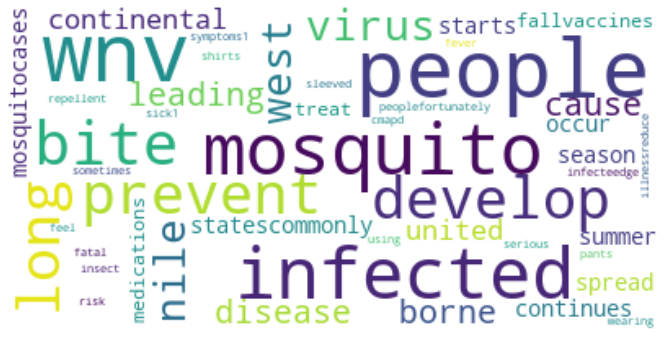

In [248]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud_text = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(''.join(sentences_c))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.axis("off")
plt.show()

### Load GloVe Word Embeddings

In [249]:
embedding_path = '/Users/guathwalow/Downloads/glove.6B.100d'
#convert_to_binary(embedding_path)  #one-time execution to create .vocab, .npy file
word_embeddings = load_embeddings_binary(embedding_path)

### Create sentence vectors

In [250]:
sentence_vectors = create_sentence_vectors(sentences_c,word_embeddings)

In [251]:
len(sentence_vectors), len(sentence_vectors[0])  # 8 sentences, 100 columns each

(8, 100)

In [252]:
sentence_vectors[0]

array([-0.02701154,  0.1276024 ,  0.40063167, -0.06225561,  0.08984156,
       -0.12425252,  0.36225098, -0.18589519, -0.06855522, -0.30007999,
       -0.3871039 , -0.09100355,  0.36632206,  0.13217153,  0.38814135,
       -0.09055235,  0.14118535, -0.44975902, -0.20298509, -0.38071721,
        0.35074939,  0.09888428,  0.32742359,  0.06032806,  0.15401954,
        0.40528407,  0.24439894, -0.25468821, -0.04066594, -0.22856231,
        0.17059813,  0.34450323,  0.19139315, -0.04994146,  0.12316889,
        0.04454786,  0.029992  , -0.00788865, -0.19863167,  0.36134007,
       -0.70155822,  0.15060994, -0.40007227, -0.46854517,  0.77371512,
        0.43394255,  0.46469121, -0.17501651, -0.35149894, -0.26174102,
        0.06083738,  0.20434986,  0.06007908,  0.49327316, -0.093142  ,
       -1.53619853, -0.04791564, -0.28309154,  1.11116989,  0.41401863,
        0.03519189,  0.58486792,  0.36093955, -0.0637742 ,  0.6086069 ,
        0.55099246, -0.29974275,  0.16000091,  0.4209271 , -0.09

In [253]:
## Create Sentence Similarity Matrix

In [254]:
sim_mat = get_similarity_matrix(sentences_c,sentence_vectors)

In [255]:
sim_mat.shape

(8, 8)

In [256]:
sim_mat   # 8 x 8 matrix

array([[0.        , 0.81342199, 0.75779284, 0.70870836, 0.6465662 ,
        0.79532613, 0.81467015, 0.67273874],
       [0.81342199, 0.        , 0.68963135, 0.78166591, 0.81352139,
        0.77481469, 0.83345885, 0.76479294],
       [0.75779284, 0.68963135, 0.        , 0.60107376, 0.60736661,
        0.801145  , 0.77375647, 0.63982389],
       [0.70870836, 0.78166591, 0.60107376, 0.        , 0.76510523,
        0.71863766, 0.77733041, 0.669815  ],
       [0.6465662 , 0.81352139, 0.60736661, 0.76510523, 0.        ,
        0.72666033, 0.82967249, 0.59726125],
       [0.79532613, 0.77481469, 0.801145  , 0.71863766, 0.72666033,
        0.        , 0.91129263, 0.65670767],
       [0.81467015, 0.83345885, 0.77375647, 0.77733041, 0.82967249,
        0.91129263, 0.        , 0.68194634],
       [0.67273874, 0.76479294, 0.63982389, 0.669815  , 0.59726125,
        0.65670767, 0.68194634, 0.        ]])

In [257]:
pd.DataFrame(sim_mat)

,0,1,2,3,4,5,6,7
0,0.000000,0.813422,0.757793,0.708708,0.646566,0.795326,0.814670,0.672739
1,0.813422,0.000000,0.689631,0.781666,0.813521,0.774815,0.833459,0.764793
2,0.757793,0.689631,0.000000,0.601074,0.607367,0.801145,0.773756,0.639824
3,0.708708,0.781666,0.601074,0.000000,0.765105,0.718638,0.777330,0.669815
4,0.646566,0.813521,0.607367,0.765105,0.000000,0.726660,0.829672,0.597261
5,0.795326,0.774815,0.801145,0.718638,0.726660,0.000000,0.911293,0.656708
6,0.814670,0.833459,0.773756,0.777330,0.829672,0.911293,0.000000,0.681946
7,0.672739,0.764793,0.639824,0.669815,0.597261,0.656708,0.681946,0.000000


### Sentence Scoring

In [258]:
#sentence 1 similarity score
sim_mat[0].sum() / sim_mat.sum()

0.12628603855990464

In [259]:
#sentence 2 similarity score
sim_mat[1].sum() / sim_mat.sum()

0.13263965033619965

In [260]:
nx_graph = convert_matrix_to_graph(sim_mat)
scores = score_sentences(nx_graph)

# Save score to dataframe
df_sentences['scores'] = scores.values()

In [261]:
df_sentences

,text,wordcount,clean_text,scores
0,West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.,17,west nile virus leading cause mosquito borne disease continental united states,0.126109
1,It is most commonly spread to people by the bite of an infected mosquito.,14,commonly spread people bite infected mosquito,0.131645
2,"Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.",16,cases wnv occur mosquito season starts summer continues fall,0.118994
3,There are no vaccines to prevent or medications to treat WNV in people.,13,vaccines prevent medications treat wnv people,0.122192
4,"Fortunately, most people infected with WNV do not feel sick.",10,fortunately people infected wnv feel sick,0.121399
5,About 1 in 5 people who are infecteedge_cmapd develop a fever and other symptoms.,14,1 5 people infecteedge cmapd develop fever symptoms,0.129787
6,"About 1 out of 150 infected people develop a serious, sometimes fatal, illness.",13,1 150 infected people develop serious sometimes fatal illness,0.134789
7,You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.,23,reduce risk wnv using insect repellent wearing long sleeved shirts long pants prevent mosquito bites,0.115086


### Sentence Matrix Graph

The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead. [nx_pylab.py:579]


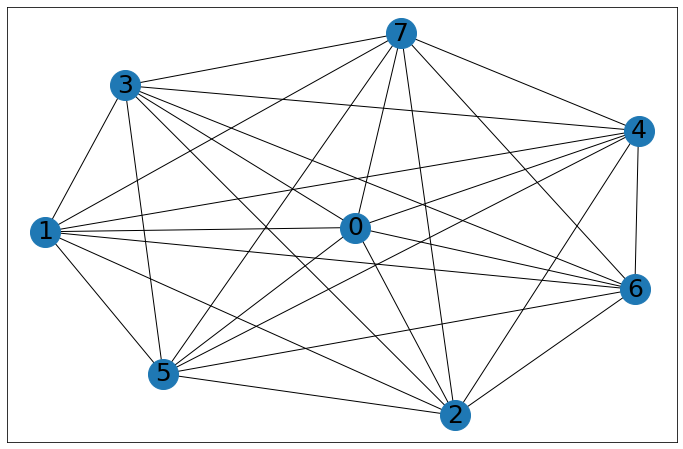

In [262]:
# Draw the network
plt.figure(figsize=(12,8))
nx.draw_networkx(nx_graph, edge_cmap='coolwarm', node_size=900, font_size=25)

### Sentence Ranking

In [263]:
# store rank in dataframe
ranked_sentences = rank_sentences(sentences,scores)
for i,r in enumerate(ranked_sentences):
    df_sentences.loc[r[2],'rank'] = i+1
df_sentences['rank'] = df_sentences['rank'].astype(int)

In [264]:
cols = ['text','scores','rank']
df_sentences[cols].head(10)

,text,scores,rank
0,West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.,0.126109,4
1,It is most commonly spread to people by the bite of an infected mosquito.,0.131645,2
2,"Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.",0.118994,7
3,There are no vaccines to prevent or medications to treat WNV in people.,0.122192,5
4,"Fortunately, most people infected with WNV do not feel sick.",0.121399,6
5,About 1 in 5 people who are infecteedge_cmapd develop a fever and other symptoms.,0.129787,3
6,"About 1 out of 150 infected people develop a serious, sometimes fatal, illness.",0.134789,1
7,You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.,0.115086,8


### Sentence Selection

In [265]:
textrank_summary = extract_top_sentences(ranked_sentences,6)
textrank_summary

['West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.',
 'It is most commonly spread to people by the bite of an infected mosquito.',
 'There are no vaccines to prevent or medications to treat WNV in people.',
 'Fortunately, most people infected with WNV do not feel sick.',
 'About 1 in 5 people who are infecteedge_cmapd develop a fever and other symptoms.',
 'About 1 out of 150 infected people develop a serious, sometimes fatal, illness.']

In [266]:
extract_top_sentences_sim_threshold(ranked_sentences,6, sim_mat, rank=False, sim_threshold = 0.90)

['West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.',
 'It is most commonly spread to people by the bite of an infected mosquito.',
 'Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.',
 'There are no vaccines to prevent or medications to treat WNV in people.',
 'Fortunately, most people infected with WNV do not feel sick.',
 'About 1 out of 150 infected people develop a serious, sometimes fatal, illness.']

# Model 2 : Centroid-Based BOW Summarization

- Refer: https://www.aclweb.org/anthology/W17-1003/
- Refer: https://github.com/gaetangate/text-summarizer/blob/master/text_summarizer/centroid_bow.py
- This model uses the bag-of-words (based on TF-IDF) to convert the words in sentences to vectors. 
It then identify the centroid vector of the document based on the sum of all the word vectors to identify keywords.
A topic threshold of 0.3 is used to check for low importance word vectors and set their values to 0. 
Scoring of sentences is done using cosine distance between the sentence vectors and centroid vector.
Selection of sentences is based on the scores. A similarity threshold is used to exclude sentences that are similar to those already in summary.

This function is used to score the similarity of 2 vectors.

In [267]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from scipy.spatial.distance import cosine
#function to score the similarity between 2 vectors
def similarity(v1, v2):
    score = 0.0
    if np.count_nonzero(v1) != 0 and np.count_nonzero(v2) != 0:
        score = ((1 - cosine(v1, v2)) + 1) / 2
    return score

This function is used to generated the summary for all the required steps.

In [268]:
def generate_summary_cbow(text, top_n):

    topic_threshold=0.3
    sim_threshold=0.95
    
    # Get list of sentences
    sentences = get_sentences(text)

    # clean all sentences
    print('cleaning sentences ...')
    sentences_c = clean_all_sentences(sentences,stop_words)

    # convert sentences to word vectors using countvectorizer
    print('converting to TFIDF ...')
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(sentences_c)

    # transform word vectors to tfidf
    transformer = TfidfTransformer(norm=None, sublinear_tf=False, smooth_idf=False)
    tfidf = transformer.fit_transform(bag_of_words)
    tfidf = tfidf.toarray()
    

    # find centroid vector
    # for sentence's centroid vector that is less than topic_threshold, set it to 0 (exclude from summary)
    print('getting sentences close to centroid vector ...')
    centroid_vector = tfidf.sum(0)
    centroid_vector = np.divide(centroid_vector, centroid_vector.max())
    for i in range(centroid_vector.shape[0]):
        if centroid_vector[i] <= topic_threshold:
            centroid_vector[i] = 0

    # sentence scoring based on similarity with the centroid vector
    print('Scoring sentences ...')
    sentences_scores = []
    for i in range(tfidf.shape[0]):
        score = similarity(tfidf[i, :], centroid_vector)
        sentences_scores.append((i, sentences[i], score, tfidf[i, :]))

    sentence_scores_sort = sorted(sentences_scores, key=lambda el: el[2], reverse=True)
    #print(sentence_scores_sort)

    # sentence selection
    print('Extracting sentences ...')
    count = 0
    sentences_summary = []
    for s in sentence_scores_sort:
        if count > top_n:
            break
        include_flag = True
        for ps in sentences_summary:
            sim = similarity(s[3], ps[3])
            
            # exclude similar sentences based on sim_threshold
            if sim > sim_threshold:
                include_flag = False
        if include_flag:
            sentences_summary.append(s)
            count += 1

    # sort the summary based on sentence order
    sentences_summary_sort = sorted(sentences_summary, key=lambda el: el[0])
    
    generated_summary = "\n".join([s[1] for s in sentences_summary_sort])
    print('Completed ...')
    return(generated_summary)      

## Sample Test Case

In this section, we ran a simple test case based on a block of text to test out all the steps.

### Read text from block

In [269]:
text = """West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. It is most commonly spread to people by the bite of an infected mosquito. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall. There are no vaccines to prevent or medications to treat WNV in people. Fortunately, most people infected with WNV do not feel sick. About 1 in 5 people who are infected develop a fever and other symptoms. About 1 out of 150 infected people develop a serious, sometimes fatal, illness. You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites."""

In [270]:
print('Number of words : ',get_wordcount(''.join(text)))
print('Number of sentences : ', get_sentencecount(text))

Number of words :  120
Number of sentences :  8


### Split text into sentences

In [271]:
sentences = get_sentences(text)

### Clean the sentences

In [272]:
sentences_c = clean_all_sentences(sentences,stop_words)

### Create sentence vectors using TFIDF

In [273]:
# create vector of word counts
cvec = CountVectorizer()
bag_of_words = cvec.fit_transform(sentences_c)
bag_of_words.shape  # 8 rows (sentences), 52 columns (vocab size)

(8, 50)

In [274]:
# Create a dataframe to store our sentence vectors
df_cvec = pd.DataFrame(bag_of_words.toarray(),
                       columns=cvec.get_feature_names())

In [275]:
df_cvec

,150,bite,bites,borne,cases,cause,commonly,continental,continues,develop,disease,fall,fatal,feel,fever,fortunately,illness,infected,insect,leading,long,medications,mosquito,nile,occur,pants,people,prevent,reduce,repellent,risk,season,serious,shirts,sick,sleeved,sometimes,spread,starts,states,summer,symptoms,treat,united,using,vaccines,virus,wearing,west,wnv
0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1


50


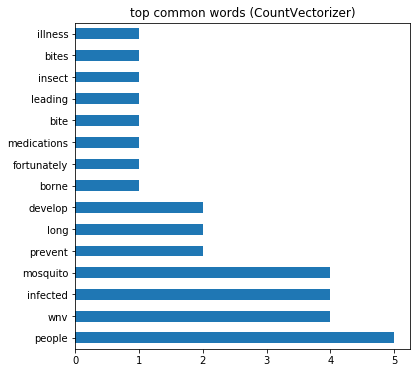

In [276]:
# Which words appear the most?
plt.figure(figsize=(6,6))

word_counts = df_cvec.sum(axis=0)
print(len(word_counts))
word_counts.sort_values(ascending = False).head(15).plot(kind='barh',title='top common words (CountVectorizer)')

In [277]:
# Apply TFIDF
transformer = TfidfTransformer(norm=None, sublinear_tf=False, smooth_idf=False)
tfidf = transformer.fit_transform(bag_of_words)
tfidf = tfidf.toarray()
tfidf.shape

(8, 50)

In [278]:
# Create a dataframe to store our sentence vectors
df_tvec = pd.DataFrame(tfidf, columns=cvec.get_feature_names())

50


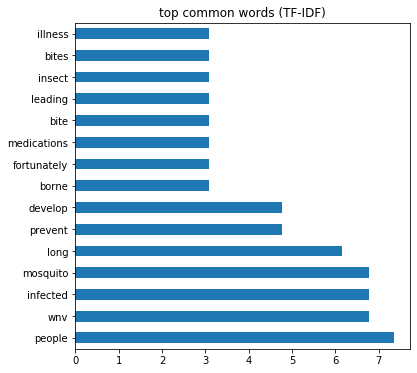

In [279]:
# Which words appear the most (TFIDF)?
plt.figure(figsize=(6,6))
word_counts = df_tvec.sum(axis=0)
print(len(word_counts))
word_counts.sort_values(ascending = False).head(15).plot(kind='barh',title='top common words (TF-IDF)')

### Find Document Centroid Vector

In this steps, we will use TF-IDF to get the important word vectors of the document. For word vector that has values less than topic threshold (0.3, meaning low importance words), we will set the vector value to 0.

In [280]:
topic_threshold=0.3
sim_threshold=0.95

centroid_vector = tfidf.sum(axis = 0)   #sum all rows for each word

In [281]:
centroid_vector.shape

(50,)

In [282]:
pd.DataFrame(centroid_vector).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,4.772589,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,6.772589,3.079442,3.079442,6.158883,3.079442,6.772589,3.079442,3.079442,3.079442,7.350018,4.772589,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,3.079442,6.772589


In [283]:
centroid_vector.max()  # most important word "people"

7.350018146228678

In [284]:
centroid_vector = np.divide(centroid_vector, centroid_vector.max())   #normalize it
pd.DataFrame(centroid_vector).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.64933,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.921438,0.418971,0.418971,0.837941,0.418971,0.921438,0.418971,0.418971,0.418971,1.0,0.64933,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.921438


In [285]:
# remove low importance word
for i in range(centroid_vector.shape[0]):
    if centroid_vector[i] <= topic_threshold:    
        centroid_vector[i] = 0

In [286]:
pd.DataFrame(centroid_vector).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.64933,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.921438,0.418971,0.418971,0.837941,0.418971,0.921438,0.418971,0.418971,0.418971,1.0,0.64933,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.418971,0.921438


In [287]:
tfidf[0]

array([0.        , 0.        , 0.        , 3.07944154, 0.        ,
       3.07944154, 0.        , 3.07944154, 0.        , 0.        ,
       3.07944154, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.07944154,
       0.        , 0.        , 1.69314718, 3.07944154, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.07944154,
       0.        , 0.        , 0.        , 3.07944154, 0.        ,
       0.        , 3.07944154, 0.        , 3.07944154, 0.        ])

### Sentence Scoring

For this step, we will score each sentence against the document centroid vector (key words). Sentences that contains these keywords will have higher scores.

In [288]:
sentences_scores = []
for i in range(tfidf.shape[0]):
    score = similarity(tfidf[i, :], centroid_vector)
    sentences_scores.append((i, sentences[i], score, tfidf[i, :]))

sentences_scores_sort = sorted(sentences_scores, key=lambda el: el[2], reverse=True)

In [289]:
pd.DataFrame([sentences_scores_sort[s][0:3] for s in range(8)],columns=['id','text','score'])

,id,text,score
0,7,You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.,0.766236
1,0,West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.,0.705768
2,6,"About 1 out of 150 infected people develop a serious, sometimes fatal, illness.",0.703451
3,2,"Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.",0.701238
4,1,It is most commonly spread to people by the bite of an infected mosquito.,0.697373
5,4,"Fortunately, most people infected with WNV do not feel sick.",0.697373
6,3,There are no vaccines to prevent or medications to treat WNV in people.,0.689877
7,5,About 1 in 5 people who are infected develop a fever and other symptoms.,0.684803


### Sentence Ranking & Selection

For this step, we will extract top sentences based on the score and at the sametime, check if the selected sentence are similar to those that are already selected. The checking of similarity is based on the similarity threshold value set.

In [290]:
top_n = 4
sim_threshold = 0.95
count = 1
sentences_summary = []
for s in sentences_scores_sort:
    if count > top_n:
        break
    include_flag = True
    for ps in sentences_summary:
        sim = similarity(s[3], ps[3])

        # exclude similar sentences based on sim_threshold
        if sim > sim_threshold:
            include_flag = False
    if include_flag:
        sentences_summary.append(s)
        count += 1

In [291]:
sentences_summary[0]

(7,
 'You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.',
 0.7662357470135466,
 array([0.        , 0.        , 3.07944154, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 3.07944154, 0.        ,
        6.15888308, 0.        , 1.69314718, 0.        , 0.        ,
        3.07944154, 0.        , 2.38629436, 3.07944154, 3.07944154,
        3.07944154, 0.        , 0.        , 3.07944154, 0.        ,
        3.07944154, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.07944154,
        0.        , 0.        , 3.07944154, 0.        , 1.69314718]))

In [292]:
len(sentences_summary)

4

In [293]:
# print the top sentences based on score
for i in range(top_n):
    print(sentences_summary[i][0:3])

(7, 'You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.', 0.7662357470135466)
(0, 'West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.', 0.7057679202239908)
(6, 'About 1 out of 150 infected people develop a serious, sometimes fatal, illness.', 0.7034508216842327)
(2, 'Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.', 0.7012380031538742)


In [294]:
# print the top sentences based on sentence order
sentences_summary_sort = sorted(sentences_summary, key=lambda el: el[0])
for i in range(top_n):
    print(sentences_summary_sort[i][0:3])

(0, 'West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.', 0.7057679202239908)
(2, 'Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.', 0.7012380031538742)
(6, 'About 1 out of 150 infected people develop a serious, sometimes fatal, illness.', 0.7034508216842327)
(7, 'You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.', 0.7662357470135466)


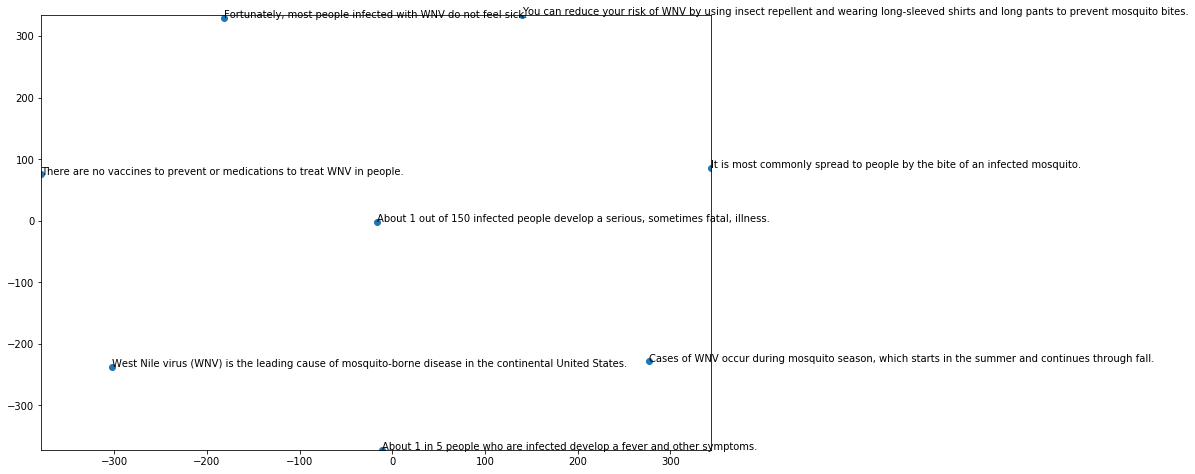

In [295]:
# visualistion of sentences vector
word_labels = sentences

from sklearn.manifold import TSNE
# find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(tfidf)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot

plt.figure(figsize=(12,8))
plt.scatter(x_coords, y_coords)

for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

# Model 3 : Pre-Trained Bert Summarizer

This tool utilizes the HuggingFace Pytorch transformers library to run extractive summarizations. This works by first embedding the sentences, then running a clustering algorithm, finding the sentences that are closest to the cluster's centroids. This library also uses coreference techniques, utilizing the https://github.com/huggingface/neuralcoref library to resolve words in summaries that need more context. The greedyness of the neuralcoref library can be tweaked in the SingleModel class.

Paper: https://arxiv.org/abs/1906.04165
- https://pypi.org/project/bert-extractive-summarizer/

In [296]:
#to test bert summarizer
#pip install bert-extractive-summarizer
#pip install spacy==2.1.0    #if you have higher version, do pip uninstall spacy
#pip install transformers

from summarizer import Summarizer

In [297]:
def generate_summary_bert(text,sent_count, num_sentences_to_match):
    bert_model = Summarizer()
    generated_summary = bert_model(text,num_sentences_to_match/sent_count)
    return(generated_summary)

## Sample Test Case

### Read text from block

In [298]:
#text = input('Copy and paste your text here')
text = """West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. It is most commonly spread to people by the bite of an infected mosquito. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall. There are no vaccines to prevent or medications to treat WNV in people. Fortunately, most people infected with WNV do not feel sick. About 1 in 5 people who are infected develop a fever and other symptoms. About 1 out of 150 infected people develop a serious, sometimes fatal, illness. You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites."""

In [299]:
print('Number of words : ',get_wordcount(''.join(text)))
print('Number of sentences : ', get_sentencecount(text))

Number of words :  120
Number of sentences :  8


In [300]:
top_n = 4
sent_count = get_sentencecount(text)
generate_summary_bert(text,sent_count, top_n)

'West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. It is most commonly spread to people by the bite of an infected mosquito. There are no vaccines to prevent or medications to treat WNV in people. About 1 in 5 people who are infected develop a fever and other symptoms.'

# Model Evaluation

## Rouge Metrics

The performance of a text summarization system is measured by its ROUGE score. ROUGE score measures the overlap between predicted and ground truth summary. ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. 
- ROUGE-1 refers to overlap of unigrams 
- ROUGE-2 refers to overlap of bigrams
- ROUGE-L –  measures longest matching sequence of words using LCS. An advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order. (Note. LCS = Longest common subsequence)

Recall in the context of ROUGE simply means how much of the reference summary is the system summary recovering or capturing.

Recall = (number of overlapping words) / (total words in reference summary)

In terms of precision, what you are essentially measuring is, how much of the model summary was in fact relevant or needed.

Precision = (number of overlapping words) / (total words in generated summary)



## DataSet : BBC News Articles / Summaries

The BBC News dataaset consists of 2223 Articles and Summaries based on 5 categories : Tech, Sport, Politics, Entertainment, Business.

These articles were fed into all the three models for summary generation and scoring against BBC summary based on Rouge Metrics.

In [301]:
def score_summary(generated_summary, reference_summary):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary,reference_summary)
    return scores

In [302]:
# Function to score generated summary with BBC summary
def evaluate_bbc_summary(file, model):
    
    # get summary file 
    print('file : ',file)
    file_summary = file.replace('NewsArticles','Summaries')
    bbc_summary = readFile(file_summary)
    bbc_summary = ''.join(bbc_summary).replace('.','. ')
    num_sentences_to_match = len(bbc_summary.split('.'))-1
    print('Number of Sentences to match: ',num_sentences_to_match)

    # get generated summary
    text = readFile(file)
    text_sent_count = get_sentencecount(text)
    text_word_count = get_wordcount(''.join(text))
    if model == 'textrank':
        generated_summary = generate_summary_textrank(text,num_sentences_to_match,word_embeddings)
    elif model == 'cbow':
        generated_summary = generate_summary_cbow(text,num_sentences_to_match)
    elif model == 'bert':
        generated_summary = generate_summary_bert(text,text_sent_count,num_sentences_to_match)
    summary_sent_count = get_sentencecount(generated_summary)
    summary_word_count = get_wordcount(''.join(generated_summary))
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary,bbc_summary)
    return text_sent_count, text_word_count,summary_sent_count, summary_word_count,model,scores

## Model 1 Graph Based Summarization Evaluation

### One Sample

In [303]:
file = '../dataset/NewsArticles/tech/005.txt'
text = readFile(file)

file_summary = '../dataset/Summaries/tech/005.txt'
bbc_summary = readFile(file_summary)
bbc_summary = ''.join(bbc_summary).replace('.','. ')
num_sentences_to_match = len(bbc_summary.split('.'))-1

In [304]:
textrank_summary = generate_summary_textrank(text, num_sentences_to_match, word_embeddings)

cleaning sentences ...
creating word vectors for sentences ...
creating sentence similarity matrix ...
scoring sentences ...
ranking sentences ...
generating summary ...
completed


In [305]:
score_summary(textrank_summary,bbc_summary)

[{'rouge-1': {'f': 0.6635730808546465,
   'p': 0.6383928571428571,
   'r': 0.6908212560386473},
  'rouge-2': {'f': 0.5586924169979843,
   'p': 0.5386819484240688,
   'r': 0.5802469135802469},
  'rouge-l': {'f': 0.6568919538033814,
   'p': 0.6339285714285714,
   'r': 0.6859903381642513}}]

In [306]:
textrank_summary = generate_summary_textrank_sim_threshold(text, num_sentences_to_match, word_embeddings)

cleaning sentences ...
creating word vectors for sentences ...
creating sentence similarity matrix ...
scoring sentences ...
ranking sentences ...
generating summary ...
completed


In [307]:
score_summary(textrank_summary,bbc_summary)

[{'rouge-1': {'f': 0.6235011940410262,
   'p': 0.6190476190476191,
   'r': 0.6280193236714976},
  'rouge-2': {'f': 0.4960998389943561,
   'p': 0.501577287066246,
   'r': 0.49074074074074076},
  'rouge-l': {'f': 0.6186410010880787,
   'p': 0.6142857142857143,
   'r': 0.6231884057971014}}]

### All Samples

Rouge Scores for generated summaries vs BBC summaries. The scores are found in files in dataset folder.

In [308]:
techscore = pd.read_csv('../dataset/Model/textrank_techscore.csv')
sportscore = pd.read_csv('../dataset/Model/textrank_sportscore.csv')
politicsscore = pd.read_csv('../dataset/Model/textrank_politicsscore.csv')
entertainmentscore = pd.read_csv('../dataset/Model/textrank_entertainmentscore.csv')
businessscore = pd.read_csv('../dataset/Model/textrank_businessscore.csv')
techscore.drop('Unnamed: 0',axis=1, inplace=True)
sportscore.drop('Unnamed: 0',axis=1, inplace=True)
politicsscore.drop('Unnamed: 0',axis=1, inplace=True)
entertainmentscore.drop('Unnamed: 0',axis=1, inplace=True)
businessscore.drop('Unnamed: 0',axis=1, inplace=True)

In [309]:
textrankall_scores = techscore.append(sportscore).append(politicsscore).append(entertainmentscore).append(businessscore)
len(textrankall_scores)

2223

In [310]:
textrankall_scores.head()

,cat,file,text_sentence_count,text_word_count,summary_sentence_count,summary_word_count,model,rouge_1_p,rouge_1_r,rouge_2_p,rouge_2_r,rouge_L_p,rouge_L_r
0,tech,../dataset/NewsArticles/tech/289.txt,23,455,10,257,textrank,0.758389,0.830882,0.637860,0.759804,0.758389,0.830882
1,tech,../dataset/NewsArticles/tech/262.txt,10,223,7,148,textrank,0.591837,0.983051,0.577778,0.962963,0.591837,0.983051
2,tech,../dataset/NewsArticles/tech/276.txt,27,592,11,317,textrank,0.740541,0.856250,0.658784,0.776892,0.729730,0.843750
3,tech,../dataset/NewsArticles/tech/060.txt,15,278,6,140,textrank,0.543689,0.736842,0.426471,0.585859,0.543689,0.736842
4,tech,../dataset/NewsArticles/tech/074.txt,25,514,11,282,textrank,0.564417,0.724409,0.437008,0.575130,0.546012,0.700787


In [311]:
cols = ['rouge_1_p','rouge_1_r','rouge_2_p','rouge_2_r','rouge_L_p','rouge_L_r']
textrankall_scores.describe()[cols]

,rouge_1_p,rouge_1_r,rouge_2_p,rouge_2_r,rouge_L_p,rouge_L_r
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,0.645857,0.745650,0.558178,0.653171,0.639976,0.739026
std,0.127357,0.128882,0.145569,0.159352,0.129961,0.133364
min,0.155844,0.207547,0.010989,0.011628,0.155844,0.207547
25%,0.564103,0.670271,0.461538,0.554035,0.556541,0.661017
50%,0.645570,0.752809,0.559322,0.661692,0.640212,0.745098
75%,0.730633,0.833333,0.652386,0.759494,0.726253,0.829108
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [312]:
textrankall_scores[textrankall_scores['file'] == '../dataset/NewsArticles/tech/005.txt']

,cat,file,text_sentence_count,text_word_count,summary_sentence_count,summary_word_count,model,rouge_1_p,rouge_1_r,rouge_2_p,rouge_2_r,rouge_L_p,rouge_L_r
135,tech,../dataset/NewsArticles/tech/005.txt,37,819,15,370,textrank,0.638393,0.690821,0.538682,0.580247,0.633929,0.68599


Based on the rouge scores obtained on the 2223 summaries, the generated summaries has a mean recall score of 74% for rouge-1, 65% for rouge-2 and 73% for rouge-L.

## Model 2 Centroid Based Summarization Evaluation

### One sample

In [313]:
file = '../dataset/NewsArticles/tech/005.txt'
text = readFile(file)

file_summary = '../dataset/Summaries/tech/005.txt'
bbc_summary = readFile(file_summary)
bbc_summary = ''.join(bbc_summary).replace('.','. ')
num_sentences_to_match = len(bbc_summary.split('.'))-1

In [314]:
cbow_summary = generate_summary_cbow(text, num_sentences_to_match)

cleaning sentences ...
converting to TFIDF ...
getting sentences close to centroid vector ...
Scoring sentences ...
Extracting sentences ...
Completed ...


In [315]:
score_summary(cbow_summary,bbc_summary)

[{'rouge-1': {'f': 0.8229885007587793,
   'p': 0.7850877192982456,
   'r': 0.8647342995169082},
  'rouge-2': {'f': 0.7503566284094662,
   'p': 0.6976127320954907,
   'r': 0.8117283950617284},
  'rouge-l': {'f': 0.8191790936190494,
   'p': 0.7850877192982456,
   'r': 0.8647342995169082}}]

### All Samples

Rouge Scores for generated summaries vs BBC summaries. The scores are found in files in dataset folder.

In [316]:
cbowtechscore = pd.read_csv('../dataset/Model/cbow_techscore.csv')
cbowsportscore = pd.read_csv('../dataset/Model/cbow_sportscore.csv')
cbowpoliticsscore = pd.read_csv('../dataset/Model/cbow_politicsscore.csv')
cbowentertainmentscore = pd.read_csv('../dataset/Model/cbow_entertainmentscore.csv')
cbowbusinessscore = pd.read_csv('../dataset/Model/cbow_businessscore.csv')
cbowtechscore.drop('Unnamed: 0',axis=1, inplace=True)
cbowsportscore.drop('Unnamed: 0',axis=1, inplace=True)
cbowpoliticsscore.drop('Unnamed: 0',axis=1, inplace=True)
cbowentertainmentscore.drop('Unnamed: 0',axis=1, inplace=True)
cbowbusinessscore.drop('Unnamed: 0',axis=1, inplace=True)

In [317]:
cbowall_scores = cbowtechscore.append(cbowsportscore).append(cbowpoliticsscore).append(cbowentertainmentscore).append(cbowbusinessscore)
len(cbowall_scores)

2223

In [318]:
cbowall_scores.sort_values(by=['cat','file']).sample(10)

,cat,file,text_sentence_count,text_word_count,summary_sentence_count,summary_word_count,model,rouge_1_p,rouge_1_r,rouge_2_p,rouge_2_r,rouge_L_p,rouge_L_r
467,sport,../dataset/NewsArticles/sport/287.txt,15,329,5,195,cbow,0.779412,0.861789,0.723164,0.820513,0.779412,0.861789
153,tech,../dataset/NewsArticles/tech/206.txt,30,658,13,352,cbow,0.766667,0.793103,0.687307,0.727869,0.766667,0.793103
447,sport,../dataset/NewsArticles/sport/319.txt,6,128,4,101,cbow,0.539474,0.788462,0.428571,0.724138,0.539474,0.788462
181,tech,../dataset/NewsArticles/tech/036.txt,10,225,5,101,cbow,0.633333,0.745098,0.522727,0.657143,0.616667,0.725490
33,sport,../dataset/NewsArticles/sport/261.txt,8,155,5,105,cbow,0.797297,0.967213,0.710000,0.946667,0.797297,0.967213
353,tech,../dataset/NewsArticles/tech/047.txt,17,327,8,157,cbow,0.682692,0.806818,0.601399,0.741379,0.682692,0.806818
264,entertainment,../dataset/NewsArticles/entertainment/378.txt,19,399,10,219,cbow,0.484615,0.630000,0.390244,0.563380,0.484615,0.630000
186,business,../dataset/NewsArticles/business/373.txt,8,174,5,127,cbow,0.826087,0.987013,0.747899,0.967391,0.826087,0.987013
326,business,../dataset/NewsArticles/business/227.txt,9,193,5,123,cbow,0.773810,0.970149,0.685950,0.943182,0.773810,0.970149
241,business,../dataset/NewsArticles/business/426.txt,22,413,10,219,cbow,0.715232,0.800000,0.625592,0.691099,0.708609,0.792593


In [319]:
cols = ['rouge_1_p','rouge_1_r','rouge_2_p','rouge_2_r','rouge_L_p','rouge_L_r']
cbowall_scores.describe()[cols]

,rouge_1_p,rouge_1_r,rouge_2_p,rouge_2_r,rouge_L_p,rouge_L_r
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,0.704003,0.859584,0.628502,0.800870,0.701721,0.856753
std,0.127298,0.102573,0.136264,0.128227,0.128548,0.105363
min,0.204545,0.463158,0.070796,0.181818,0.170455,0.394737
25%,0.622300,0.793218,0.537828,0.719405,0.618846,0.789268
50%,0.718310,0.866667,0.639810,0.811111,0.716814,0.864407
75%,0.801802,0.941224,0.731763,0.898900,0.800000,0.939707
max,0.975460,1.000000,0.936975,1.000000,0.975460,1.000000


Based on the rouge scores obtained on the 2223 summaries, the generated summaries has a mean recall score of 85% for rouge-1, 80% for rouge-2 and 85% for rouge-L. This model is able to generate summaries similar to those in the BBC dataset.

## Model 3 Pre-Trained Bert Summarization Evaluation

### One Sample

In [320]:
file_summary = '../dataset/Summaries/tech/005.txt'
bbc_summary = readFile(file_summary)
bbc_summary = ''.join(bbc_summary).replace('.','. ')
num_sentences_to_match = len(bbc_summary.split('.'))-1

In [321]:
file = '../dataset/NewsArticles/tech/005.txt'
text = readFile(file)
text_sent_count = get_sentencecount(text)
bert_summary = generate_summary_bert(text,text_sent_count, num_sentences_to_match)
bert_summary

'Technology gets the creative bug The hi-tech and the arts worlds have for some time danced around each other and offered creative and technical help when required. Often this help has come in the form of corporate art sponsorship or infrastructure provision. UK telco BT is serious about the idea and has launched its Connected World initiative. The river was integral to the city\'s survival for hundreds of years and it was equally essential to the city that it disappeared," said the artists. " In their previous works they used the Quake game graphics engine. The game engine is the core component of a video game because it handles graphics rendering, game AI, and how objects behave and relate to each other in a game. But collaboration between art and digital technology is by no means new, and many keen coders, designers, games makers and animators argue that what they create is art itself. The Orange Expressionist exhibition last year, for example, displayed thousands of picture message

In [322]:
score_summary(bert_summary, bbc_summary)

[{'rouge-1': {'f': 0.6102564052753452,
   'p': 0.6502732240437158,
   'r': 0.5748792270531401},
  'rouge-2': {'f': 0.49430893810382714,
   'p': 0.5223367697594502,
   'r': 0.4691358024691358},
  'rouge-l': {'f': 0.6005964703831381,
   'p': 0.644808743169399,
   'r': 0.5700483091787439}}]

### 50 Samples

Rouge Scores for generated summaries vs BBC summaries. The scores are found in files in dataset folder.

In [323]:
berttechscore = pd.read_csv('../dataset/Model/bert_techscore50.csv')
berttechscore.drop('Unnamed: 0',axis=1, inplace=True)
cols = ['rouge_1_p','rouge_1_r','rouge_2_p','rouge_2_r','rouge_L_p','rouge_L_r']
berttechscore.describe()[cols]

,rouge_1_p,rouge_1_r,rouge_2_p,rouge_2_r,rouge_L_p,rouge_L_r
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.545953,0.604088,0.416369,0.449464,0.531754,0.588876
std,0.083112,0.131060,0.107175,0.162793,0.086798,0.135262
min,0.346154,0.360360,0.156716,0.168000,0.326923,0.333333
25%,0.484630,0.513648,0.352172,0.343065,0.470569,0.502419
50%,0.544885,0.573849,0.432403,0.419080,0.544167,0.550356
75%,0.598034,0.683388,0.492693,0.532398,0.589510,0.680518
max,0.757143,0.983051,0.685185,0.962963,0.750000,0.983051


Based on the rouge scores obtained on the 50 summaries (it takes 30s to generate one summary), the generated summaries has a mean recall score of 60% for rouge-1, 45% for rouge-2 and 59% for rouge-L. This is the lowest among the 3 models.

# Conclusions

# References